# Supplementary figure (Allele-specific counts)

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import patac as pa
from functools import partial

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Data files

In [8]:
variant_overlap = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/peak_variant_overlaps.txt' % exp_id

In [9]:
reads_total = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/alignment/reads_total.txt' % exp_id
reads_wasp = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/alignment/reads_wasp.txt' % exp_id

In [10]:
reads_allelic_total = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/counts/reads_total.txt' % exp_id
reads_allele1 = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/counts/reads_allele1.txt' % exp_id
reads_allele2 = lambda exp_id: '/icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_pipeline/data/processed/%s/counts/reads_allele2.txt' % exp_id

In [11]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [12]:
leiden_colors = pd.Series(dict(zip(adata_total.obs['leiden_vae'].cat.categories, adata_total.uns['leiden_vae_colors'])))
timepoint_colors = pd.Series(dict(zip(adata_total.obs['timepoint'].cat.categories, adata_total.uns['timepoint_colors'])))
exp_id_colors = pd.Series(dict(zip(adata_total.obs['exp_id'].cat.categories, adata_total.uns['exp_id_colors'])))

In [13]:
# extract actual timepoints and experiment ids
timepoints = adata_total.obs['timepoint'].unique().tolist()
exp_ids = adata_total.obs['exp_id'].unique().tolist()

In [14]:
# load allele-specific counts
adatas_allelic = dict()
for exp_id in exp_ids:
    adata = dataloader.load_allelic(
        exp_ids=exp_id,
        timepoints=timepoints,
        wasp_corrected=wasp_corrected,
        regions=regions)
    
    # filter for cells present in adata_total
    cell_names = adata_total.obs.query('exp_id == @exp_id').index
    adata = adata[cell_names, :]

    # copy cell states and annotations
    adata.obsm = adata_total[cell_names, :].obsm
    adata.obs['time_vae'] = adata_total[cell_names, :].obs['time_vae']
    adata.obs['leiden_vae'] = adata_total[cell_names, :].obs['leiden_vae']
    adata.obs['lineage_muscle'] = adata_total[cell_names, :].obs['lineage_muscle']
    adata.obs['lineage_nervous'] = adata_total[cell_names, :].obs['lineage_nervous']
    adata.obs['annotation'] = adata_total[cell_names, :].obs['annotation']
    for key in adata_total.uns.keys():
        if 'color' in key:
            adata.uns[key] = adata_total.uns[key]
    adatas_allelic[exp_id] = adata

Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS148.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS148.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS157.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS157.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS158.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS158.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS159.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cach

Remove sex chromosomes, filter very lowly covered peaks

In [15]:
for exp_id, adata in adatas_allelic.items():
    adata = pa.pp.apply_to_layer(
        adata,
        layer='allelic_total',
        func=partial(sc.pp.filter_genes, min_cells=50))
    n_peaks = adata.shape[1]
    pa.pp.filter_chromosomes(adata, chrs=['chrX', 'chrY'])
    print('filtered out %d peaks on sex chromosomes, %d remaining' % (n_peaks - adata.shape[1], adata.shape[1]))
    adata = pa.pp.apply_to_layer(
        adata,
        layer='allelic_total',
        func=pa.pp.calculate_qc_metrics)

    adata.var['allelic_counts'] = adata.X.sum(0).A1
    adata.var['mean_accessible'] = adata.var['total_counts'] / adata.var['n_cells_by_counts']
    adatas_allelic[exp_id] = adata

filtered out 6023 peaks on sex chromosomes, 36596 remaining
filtered out 5453 peaks on sex chromosomes, 34918 remaining
filtered out 5636 peaks on sex chromosomes, 35603 remaining
filtered out 5323 peaks on sex chromosomes, 34706 remaining


In [16]:
cross_colors = dict(zip(adata_total.obs['exp_id'].cat.categories.tolist(), adata_total.uns['exp_id_colors']))

In [17]:
F1_IDS = 'F1-' + pd.read_csv(settings.EXPERIMENT_INFO, sep='\t', index_col=0)['paternal_id']

## Plot settings

In [18]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [19]:
FIGURE_NUMBER = 'supp24'
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%s' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Plot read distribution

In [20]:
keys = ['mean_counts', 'total_counts']
df = pd.DataFrame()
ncells = dict()
for exp_id, adata in adatas_allelic.items():
    df_exp_id = adata.var[keys].copy()
    df_exp_id['log_total_counts'] = np.log10(df_exp_id['total_counts'])
    df_exp_id['passed_filter'] = df_exp_id['total_counts'] > .1 * adata.shape[0]
    df_exp_id['Cross'] = F1_IDS[exp_id]
    ncells[F1_IDS[exp_id]] = adata.shape[0]
    df = df.append(df_exp_id)

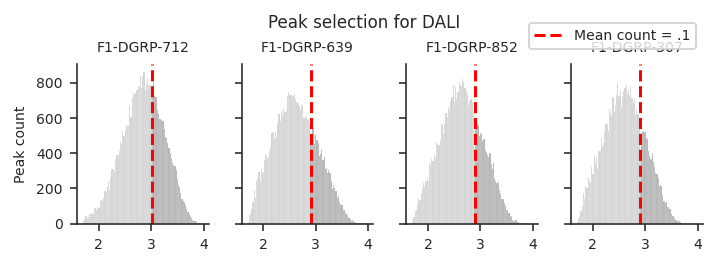

In [21]:
g = sns.displot(x='log_total_counts', hue='passed_filter', data=df, col='Cross', aspect=.7, legend=False, palette=['darkgrey', 'dimgrey'], height=1.8)
for ax in g.fig.axes:
    ax.axvline(np.log10(.1 * ncells[ax.get_title().replace('Cross = ', '')]), label='Mean count = .1', linestyle='--', color='red')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3))

g.set_axis_labels(y_var='Peak count', x_var='')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Peak selection for DALI', y=1.05)
save_panel(g.fig)

## Number of variants per peak

In [22]:
variant_overlaps = pd.DataFrame()
for exp_id in settings.F1_EXP_IDS:
    df = pd.read_csv(variant_overlap(exp_id), sep='\t', header=None, names=['chr', 'start', 'end', 'count'])
    df['exp_id'] = exp_id
    variant_overlaps = pd.concat([variant_overlaps, df])

In [23]:
variant_overlaps = variant_overlaps.query('(chr != "chrX") and (chr != "chrY")')

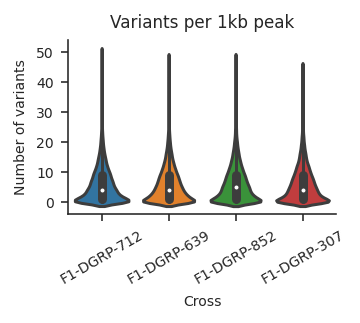

In [24]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.violinplot(x='exp_id', y='count', data=variant_overlaps, ax=ax)
ax.set(xlabel='Cross', ylabel='Number of variants', title='Variants per 1kb peak')
ax.set_xticklabels([F1_IDS[label.get_text()] for label in ax.get_xticklabels()], rotation=30)
sns.despine()
save_panel(fig)

In [25]:
variant_overlaps.groupby('exp_id')['count'].mean()

exp_id
SS148    5.759810
SS157    5.879633
SS158    6.044922
SS159    5.893264
Name: count, dtype: float64

## Number of mapped reads before and after WASP

In [26]:
mapped_reads = pd.DataFrame()
for exp_id in settings.F1_EXP_IDS:
    df = pd.read_csv(reads_total(exp_id), names=['Readcount'])
    df['exp_id'] = exp_id
    df['filter'] = 'Before WASP'
    mapped_reads = pd.concat([mapped_reads, df])
    df = pd.read_csv(reads_wasp(exp_id), names=['Readcount'])
    df['exp_id'] = exp_id
    df['filter'] = 'After WASP'
    mapped_reads = pd.concat([mapped_reads, df])

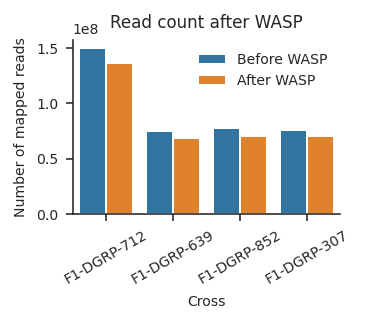

In [27]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.barplot(x='exp_id', y='Readcount', hue='filter', data=mapped_reads, ax=ax)
ax.set(xlabel='Cross', ylabel='Number of mapped reads', title='Read count after WASP')
ax.set_xticklabels([F1_IDS[label.get_text()] for label in ax.get_xticklabels()], rotation=30)
plt.legend(frameon=False, title='')
sns.despine()
save_panel(fig)

In [28]:
1 - mapped_reads.query('filter == "After WASP"')['Readcount'] / mapped_reads.query('filter == "Before WASP"')['Readcount']

0    0.089776
0    0.084636
0    0.089931
0    0.076030
Name: Readcount, dtype: float64

## Number of reads mapping to either allele

In [29]:
mapped_reads = pd.DataFrame()
for exp_id in settings.F1_EXP_IDS:
    df = pd.read_csv(reads_allelic_total(exp_id), names=['Readcount'])
    df['exp_id'] = exp_id
    df['mapped'] = 'Unassigned'
    mapped_reads = pd.concat([mapped_reads, df])
    
    df = pd.read_csv(reads_allele1(exp_id), names=['Readcount'])
    df += pd.read_csv(reads_allele2(exp_id), names=['Readcount'])
    df['exp_id'] = exp_id
    df['mapped'] = 'Assigned'
    mapped_reads = pd.concat([mapped_reads, df])

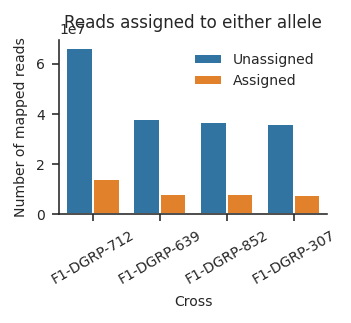

In [30]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
sns.barplot(x='exp_id', y='Readcount', hue='mapped', data=mapped_reads, ax=ax)
ax.set(xlabel='Cross', ylabel='Number of mapped reads', title='Reads assigned to either allele')
ax.set_xticklabels([F1_IDS[label.get_text()] for label in ax.get_xticklabels()], rotation=30)
plt.legend(frameon=False, title='')
sns.despine()
save_panel(fig)

In [31]:
mapped_reads.query('mapped == "Assigned"')['Readcount'] / mapped_reads.query('mapped == "Unassigned"')['Readcount']

0    0.211568
0    0.214337
0    0.220080
0    0.209651
Name: Readcount, dtype: float64

## Final number of regions

In [32]:
adatas_allelic = dict()
for exp_id in settings.F1_EXP_IDS:
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adatas_allelic[exp_id] = sc.read(os.path.join(settings.DATA_DIR, label, fname))

In [33]:
n_peaks = pd.DataFrame([(exp_id, adata.shape[1]) for (exp_id, adata) in adatas_allelic.items()], columns=['exp_id', 'n_peaks'])

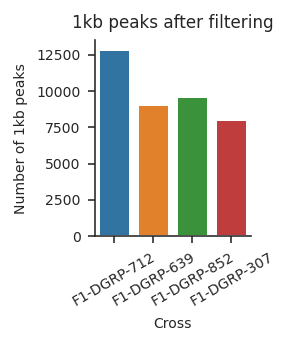

In [34]:
fig, ax = plt.subplots(figsize=(1.4, 1.8))
ax = sns.barplot(x='exp_id', y='n_peaks', data=n_peaks, ax=ax)
ax.set(xlabel='Cross', ylabel='Number of 1kb peaks', title='1kb peaks after filtering')
ax.set_xticklabels([F1_IDS[label.get_text()] for label in ax.get_xticklabels()], rotation=30)
sns.despine()
save_panel(fig)

In [35]:
n_peaks

,exp_id,n_peaks
0,SS148,12861
1,SS157,9045
2,SS158,9584
3,SS159,8040
